In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
filename = 'ISIC_2020_Training_GroundTruth.csv'
filepath = f'./data/{filename}'

df = pd.read_csv(filepath)

In [20]:
df.describe()

,age_approx,target
count,33058.000000,33126.000000
mean,48.870016,0.017630
std,14.380360,0.131603
min,0.000000,0.000000
25%,40.000000,0.000000
50%,50.000000,0.000000
75%,60.000000,0.000000
max,90.000000,1.000000


In [21]:
df.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')

In [13]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [22]:
print(f" unique patients: {df['patient_id'].nunique()}")

 unique patients: 2056


In [23]:
df_grouped_2 = df.groupby(['patient_id', 'age_approx']).count()
print(len(df_grouped_2))

3494


In [24]:
# Group by 'patient_id' and 'age_approx', and count the number of records for each group
df_grouped = df.groupby(['patient_id', 'age_approx']).size().reset_index(name='counts')

# Now, group by 'patient_id' alone to count the number of unique age_approx entries per patient
df_grouped_by_patient = df_grouped.groupby('patient_id').size()

# Filter out patients who have records for only one age_approx
patients_multiple_ages = df_grouped_by_patient[df_grouped_by_patient > 1].index

# Use this filtered list of patient_ids to filter the original DataFrame
df_filtered = df[df['patient_id'].isin(patients_multiple_ages)]

# If you want to know the number of unique patients who have records across multiple ages
unique_patients_multiple_ages = len(df_filtered['patient_id'].unique())

print(f"Number of unique patients with records across multiple ages: {unique_patients_multiple_ages}")

Number of unique patients with records across multiple ages: 997


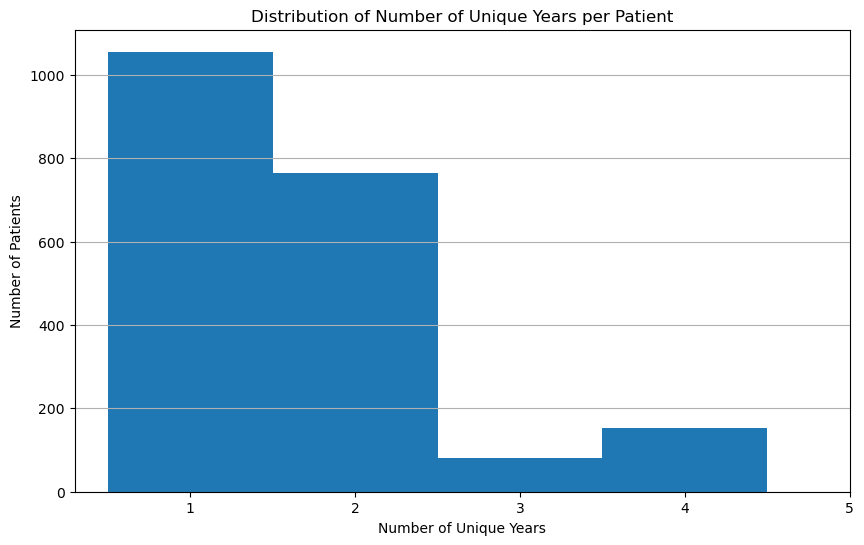

Number of patients with records for 2 or more unique years: 997


In [12]:
# Group by 'patient_id' and 'age_approx', then count unique ages per patient
df_unique_ages_per_patient = df.groupby('patient_id')['age_approx'].nunique().reset_index(name='unique_years')

# Distribution of unique years per patient
plt.figure(figsize=(10, 6))
plt.hist(df_unique_ages_per_patient['unique_years'], bins=range(1, df_unique_ages_per_patient['unique_years'].max() + 1), align='left')
plt.title('Distribution of Number of Unique Years per Patient')
plt.xlabel('Number of Unique Years')
plt.ylabel('Number of Patients')
plt.xticks(range(1, df_unique_ages_per_patient['unique_years'].max() + 1))
plt.grid(axis='y')
plt.show()

# Count how many patients have records for 2 or more unique years
patients_with_2_or_more_years = df_unique_ages_per_patient[df_unique_ages_per_patient['unique_years'] > 1].shape[0]

print(f"Number of patients with records for 2 or more unique years: {patients_with_2_or_more_years}")


In [18]:
# Filter for patients with multiple years of data first
patients_with_multiple_years = df.groupby('patient_id')['age_approx'].nunique()
patients_with_multiple_years = patients_with_multiple_years[patients_with_multiple_years > 1].index
df_filtered = df[df['patient_id'].isin(patients_with_multiple_years)]

# Initialize a list to hold patients with changes from benign to malignant at the same site
patients_with_changes_same_site = []

# Iterate over each patient to check their records
for patient_id in patients_with_multiple_years:
    patient_records = df_filtered[df_filtered['patient_id'] == patient_id]
    
    # We need to check each anatomical site separately for this patient
    for site in patient_records['anatom_site_general_challenge'].unique():
        site_records = patient_records[patient_records['anatom_site_general_challenge'] == site]
        
        # Now check if there are both benign and malignant diagnoses at this site
        if 'benign' in site_records['benign_malignant'].values and 'malignant' in site_records['benign_malignant'].values:
            patients_with_changes_same_site.append((patient_id, site))

# Calculate the unique number of patients (since one patient could have multiple sites)
unique_patients_with_changes = len(set([patient for patient, site in patients_with_changes_same_site]))

print(f"Number of unique patients with moles changing from benign to malignant at the same anatomical site: {unique_patients_with_changes}")


Number of unique patients with moles changing from benign to malignant at the same anatomical site: 216
